In [2]:
from clickhouse_connect import get_client

client = get_client(database="nyc_taxi")

bounds = client.query(f"""SELECT min(pickup_latitude), max(pickup_latitude), 
                            min(pickup_longitude), max(pickup_longitude) FROM trips_small
                            where pickup_latitude != 0 and pickup_longitude != 0""").result_rows[0]
print(bounds)


geos = client.query(f"""select pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude
                        from trips_small where pickup_latitude!=0 and pickup_longitude!=0 and
                        dropoff_latitude!=0 and dropoff_longitude!=0""")

import pandas as pd

geo_coords = pd.DataFrame(geos.result_rows, columns=geos.column_names)

(4.074332237243652, 59.761810302734375, -121.93339538574219, -7.59032678604126)


New York City's geographic coordinates roughly span from 40.49°N to 40.92°N latitude and -74.26°W to -73.70°W longitude.

In [3]:
from clickhouse_connect import get_client

client = get_client(database="nyc_taxi")

# bounds = client.query(f"""SELECT min(pickup_latitude), max(pickup_latitude), 
#                             min(pickup_longitude), max(pickup_longitude) 
#                             FROM trips_small where
#                             pickup_latitude between 40 and 41 and 
#                             pickup_longitude between -75 and -73 and
#                             dropoff_latitude between 40 and 41 and 
#                             dropoff_longitude between -75 and -73""").result_rows[0]
# print(bounds)


geos = client.query(f"""select 
                        pickup_latitude, 
                        pickup_longitude, 
                        dropoff_latitude, 
                        dropoff_longitude,
                        pickup_ntaname,
                        dropoff_ntaname
                        from trips_small"""
                         )
                        # """where 
                        # pickup_latitude between 40 and 41 and 
                        # pickup_longitude between -75 and -73 and
                        # dropoff_latitude between 40 and 41 and 
                        # dropoff_longitude between -75 and -73"""

import pandas as pd

geo_coords = pd.DataFrame(geos.result_rows, columns=geos.column_names)

In [4]:
nta_counts = geo_coords.groupby("pickup_ntaname").size().sort_values(ascending=False).copy()

In [5]:
nyc_nta = gpd.read_file("/home/alexander/Downloads/nynta2010_25d/nynta2010.shp")
nyc_nta_wm = nyc_nta.to_crs(epsg=3857)
print(nyc_nta_wm.NTAName)

0                       St. Albans
1                    East Flushing
2                          Madison
3         Kensington-Ocean Parkway
4                  Cambria Heights
                  ...             
190    park-cemetery-etc-Manhattan
191                  College Point
192                     Whitestone
193                      Rego Park
194                 Middle Village
Name: NTAName, Length: 195, dtype: object


TODO: use the same color scale for pickups and dropoffs

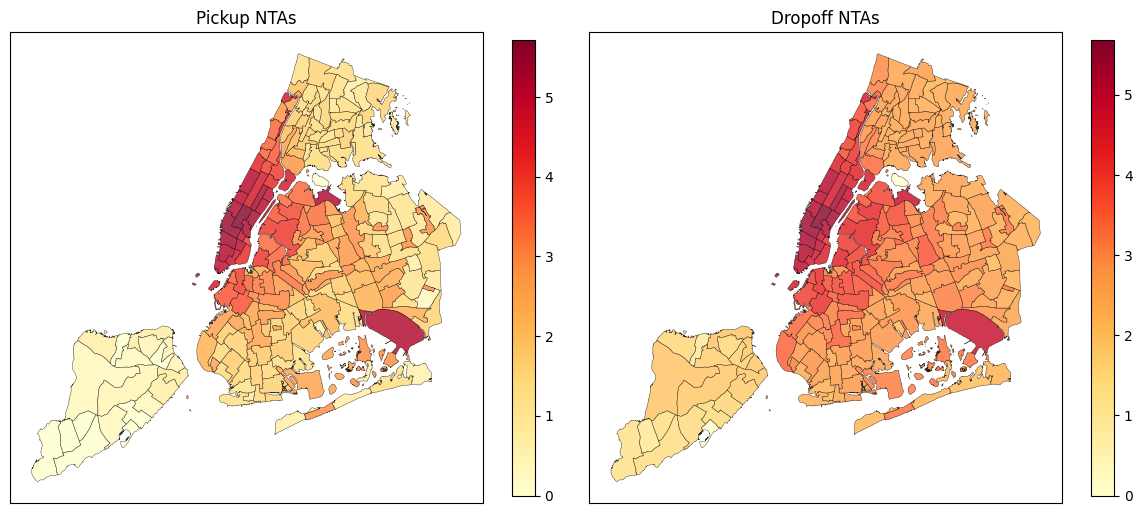

In [30]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np


def plot_nta_counts(nta_counts, nyc_nta_wm, ax):    
    # Prepare NTA counts for joining
    nta_counts_df = nta_counts.reset_index()
    nta_counts_df.columns = ['NTAName', 'count']

    # Join NTA boundaries with pickup counts
    nyc_nta_wm_with_counts = nyc_nta_wm.merge(nta_counts_df,on='NTAName',how='left')
    nyc_nta_wm_with_counts['count'] = np.log10(nyc_nta_wm_with_counts['count'].fillna(1))

    # Plot NTA boundaries colored by pickup count
    nyc_nta_wm_with_counts.plot(ax=ax,column='count',cmap='YlOrRd',edgecolor='black',linewidth=0.3,alpha=0.8,legend=True,legend_kwds={'shrink': 0.8,'orientation': 'vertical'}
    )
    # cx.add_basemap(ax, crs=nyc_nta_wm.crs, source=cx.providers.CartoDB.Positron)
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

nta_pickups = geo_coords.groupby("pickup_ntaname").size().sort_values(ascending=False).copy()
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_nta_counts(nta_pickups, nyc_nta_wm, ax[0])
ax[0].set_title("Pickup NTAs")
nta_dropoffs = geo_coords.groupby("dropoff_ntaname").size().sort_values(ascending=False).copy()
ax2 = plot_nta_counts(nta_dropoffs, nyc_nta_wm, ax[1])
ax2.set_title("Dropoff NTAs")
plt.tight_layout()
plt.show()


(2954097, 6) with 98.46% of all trips


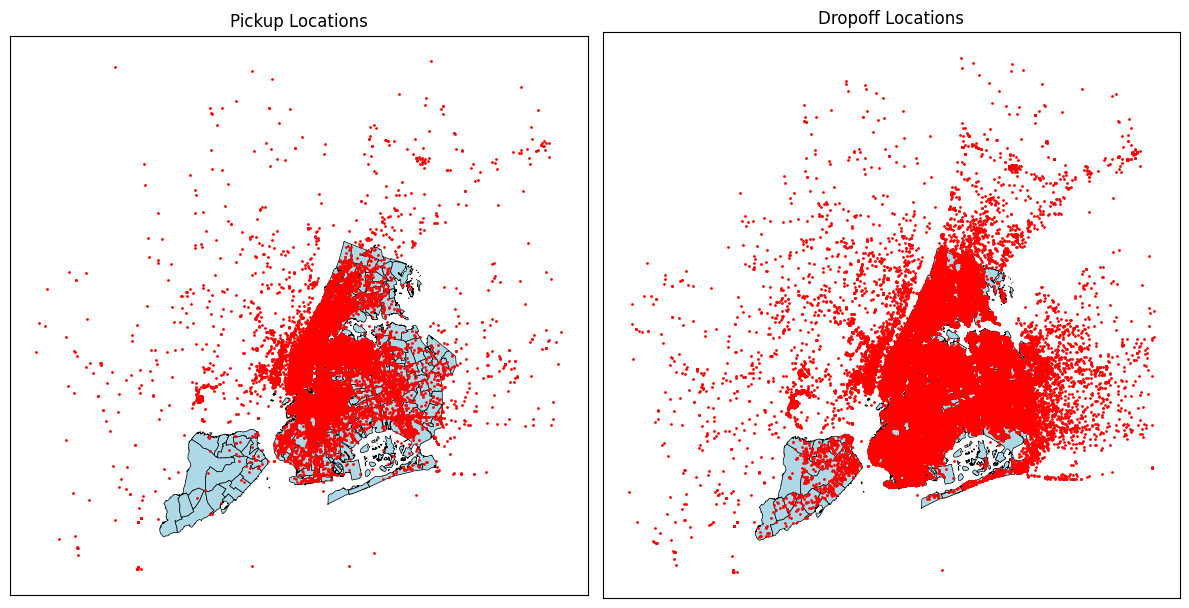

In [46]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx

geo_coords_ny = geo_coords.copy()
geo_coords_ny = geo_coords_ny[geo_coords_ny.pickup_latitude > 40.45]
geo_coords_ny = geo_coords_ny[geo_coords_ny.pickup_latitude < 41.2]
geo_coords_ny = geo_coords_ny[geo_coords_ny.pickup_longitude > -74.5]
geo_coords_ny = geo_coords_ny[geo_coords_ny.pickup_longitude < -73.5]
geo_coords_ny = geo_coords_ny[geo_coords_ny.dropoff_latitude > 40.45]
geo_coords_ny = geo_coords_ny[geo_coords_ny.dropoff_latitude < 41.2]
geo_coords_ny = geo_coords_ny[geo_coords_ny.dropoff_longitude > -74.5]
geo_coords_ny = geo_coords_ny[geo_coords_ny.dropoff_longitude < -73.5]

def plot_geo_counts(geo_coords, nyc_nta_wm):
    nyc_nta_geo = nyc_nta_wm.to_crs(epsg=4326)
    _, ax = plt.subplots(1, 2, figsize=(12, 6))
    for i in range(2):
        x = geo_coords.pickup_longitude if i == 0 else geo_coords.dropoff_longitude
        y = geo_coords.pickup_latitude if i == 0 else geo_coords.dropoff_latitude
        nyc_nta_geo.plot(ax=ax[i],alpha=1,edgecolor='black',facecolor='lightblue',linewidth=0.5,zorder=1)
        ax[i].scatter(x, y,alpha=1,s=1,c='red',zorder=2)
        # ax[i].set_xlim(-74.5, -73.5)  # NYC longitude bounds
        # ax[i].set_ylim(40.45, 41.2)    # NYC latitude bounds
        ax[i].set_title(f"{'Pickup' if i == 0 else 'Dropoff'} Locations")
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.tight_layout()
    plt.show()

print(geo_coords_ny.shape, f"with {geo_coords_ny.shape[0] / geo_coords.shape[0] * 100:.02f}% of all trips")
plot_geo_counts(geo_coords_ny, nyc_nta_wm)

Rounding the geo coords down to 2 (3) decimal places results in localization cell dimensions of approximately 1100 m x 840 m (111 m x 84 m) 

(2945412, 6) with 98.17% non-empty NTAs


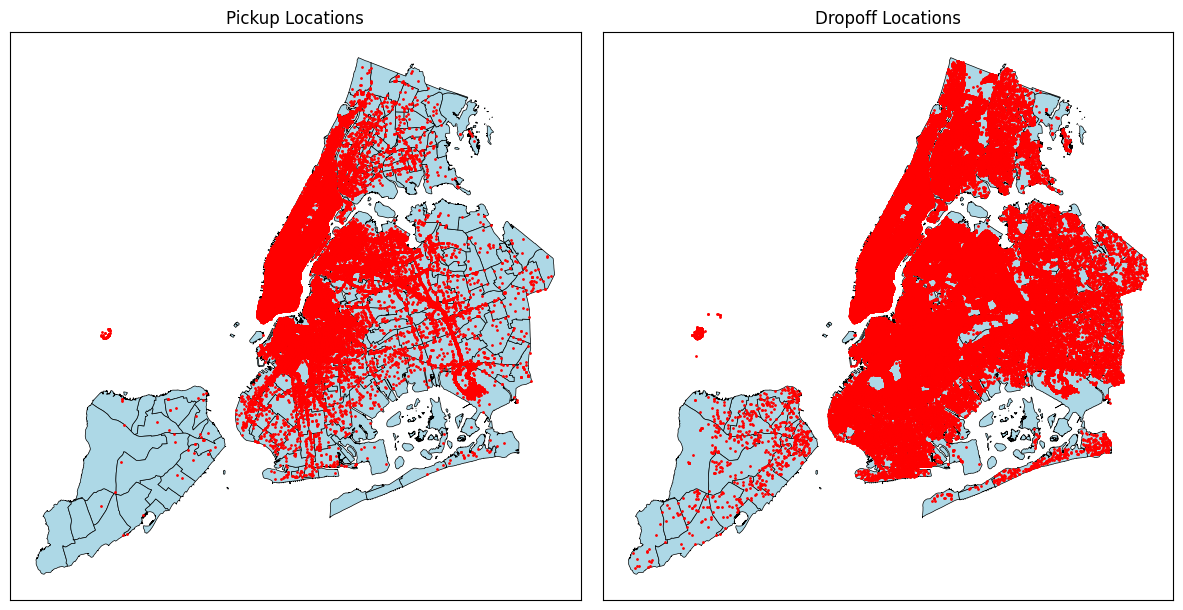

In [47]:
geo_nta_nonempty = geo_coords.copy()
geo_nta_nonempty = geo_nta_nonempty[(geo_nta_nonempty.pickup_ntaname != '') & (geo_nta_nonempty.dropoff_ntaname != '')]

print(geo_nta_nonempty.shape, f"with {geo_nta_nonempty.shape[0] / geo_coords.shape[0] * 100:.02f}% non-empty NTAs")
plot_geo_counts(geo_nta_nonempty, nyc_nta_wm)

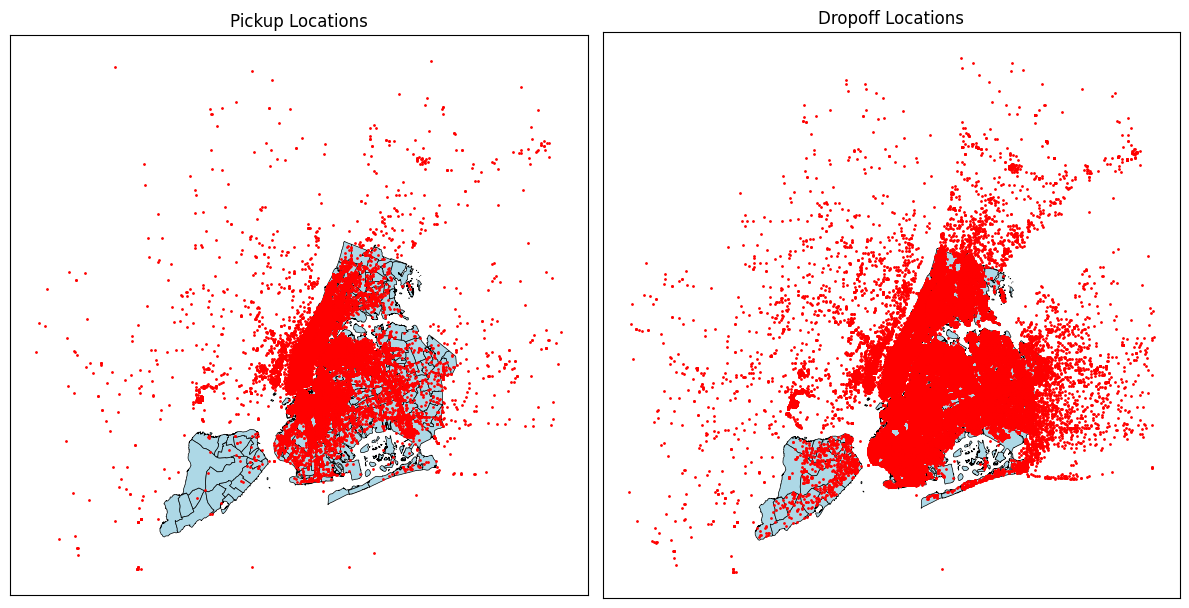

In [50]:
geo_nta_rounded = geo_coords_ny.copy()
geo_nta_rounded = geo_nta_rounded.round(3)

plot_geo_counts(geo_nta_rounded, nyc_nta_wm)


In [144]:
query = f"""with data as (select 
                cityHash64(array(round(pickup_latitude, 3), round(pickup_longitude, 3))) as uid, 
                count(trip_id) as trips,
                toDate(pickup_datetime) as date, 
                sum(total_amount) as amount
            from trips_small
            where pickup_latitude between 40.45 and 41.2 and pickup_longitude between -74.5 and -73.5
            group by uid, date
            order by date),
            labels as (
            select d1.uid, d1.date as prediction_date, d1.trips,
                if(d2.date is not null and d2.date <= d1.date + interval 7 day, 0, 1) as churn
                from data d1 asof join data d2
                on d1.uid=d2.uid
                and d1.date < d2.date
                order by date)
            select 
                trips, 
                churn,
                prediction_date,
                count(distinct uid) as n_users
            from labels
            group by trips, churn, prediction_date order by prediction_date"""


data = client.query(query)
data = pd.DataFrame(data.result_rows, columns=data.column_names)
print(data.shape)

(7399, 4)


In [145]:
print(data.head())
print(data[data.prediction_date.astype(str) == "2015-07-08"])




   trips  churn prediction_date  n_users
0     40      0      2015-07-01        1
1     81      0      2015-07-01        1
2     57      0      2015-07-01        1
3     28      0      2015-07-01        3
4      2      1      2015-07-01       13
     trips  churn prediction_date  n_users
375      6      0      2015-07-08      138
376     35      0      2015-07-08        6
377     36      0      2015-07-08        1
378      7      0      2015-07-08      112
379     65      0      2015-07-08        1
380     30      0      2015-07-08        7
381     45      0      2015-07-08        1
382     42      0      2015-07-08        1
383     70      0      2015-07-08        2
384     54      0      2015-07-08        1
385      1      1      2015-07-08      142
386      3      0      2015-07-08      268
387     93      0      2015-07-08        1
388     33      0      2015-07-08        5
389     29      0      2015-07-08        6
390     14      0      2015-07-08       42
391     26      0      